# Init

In [1]:
import torch
from torch import nn
from jlib.classifier import Classifier
from jlib.get_shakespeare_loaders import get_shakespeare_loaders

models = []
datas = []
text = ""
with open('data/sequence.txt', 'r') as f:
    text = f.read()

class ShakespeareRNN(Classifier):
    def __init__(self, alphabet_size, hidden_size, rnn=nn.RNN, linear_network=[], learning_rate = 1e-2, sequence_length = 20, dropout=0.3):
        super().__init__()
        self.learning_rate = learning_rate
        self.sequence_length = sequence_length
        self.hidden_size = hidden_size
        self.embedding = nn.Embedding(alphabet_size, hidden_size)
        self.rnn = rnn(hidden_size, hidden_size, batch_first=True)
        self.fc = nn.Sequential()
        linear_in = hidden_size
        linear_out = alphabet_size
        for i, layer_size in enumerate(linear_network):
            self.fc.add_module(f'linear_{i}', nn.Linear(linear_in, layer_size))
            self.fc.add_module(f'batchnorm_{i}', nn.BatchNorm1d(layer_size))
            self.fc.add_module(f'relu_{i}', nn.ReLU())
            self.fc.add_module(f'dropout_{i}', nn.Dropout(dropout))
            linear_in = layer_size
        self.fc.add_module('final_linear', nn.Linear(linear_in, linear_out))
        
    def forward(self, x):
        x = self.embedding(x)
        x, _ = self.rnn(x)
        x = self.fc(x[:, -1, :])  # Get the output of the last RNN cell
        return x

def train_and_plot(train, val, model: ShakespeareRNN, name, *training_args, **training_kwargs):
    print(f"Training {name}")
    param_count = sum(p.numel() for p in model.parameters())
    print(f"Model has {param_count} parameters")
    model.train_model(
        *training_args,
        **training_kwargs,
        train_loader=train,
        val_loader=val,
    )
    fig = model.plot_training(f"{name} Training")
    fig.savefig(f"images/{name}_training_new.png")
    print(f"Model has {param_count} parameters")
    model.train_model(*training_args, **training_kwargs)
    fig = model.plot_training(f"{name} Training")
    fig.savefig(f"images/{name}_training_new.png")



/home/jaskin/Intro_Deep_Learning/env/lib/python3.11/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


# Data 20

In [2]:
for data in datas:
    del data
data_20 = get_shakespeare_loaders(
    train_batch_size=2**13,
    val_batch_size=2**13,
    sequence_length=20,
)
datas.append(data_20)

Train GPU Prefetch: 3200.0
Train CPU Prefetch: 320.0
Val GPU Prefetch: 1600.0
Val CPU Prefetch: 320.0
Train Loader
Begin init data loader
Batch Size: 1.25 MiB
Data Loader init time: 3.180833 s
Begin init fetcher
Fetcher init time: 3.617322 s
Val Loader
Begin init data loader
Batch Size: 1.25 MiB
Data Loader init time: 1.284844 s
Begin init fetcher
Fetcher init time: 1.570695 s


# LSTM 20

In [3]:


for model in models:
    del model

lstm20 = ShakespeareRNN(
    alphabet_size=len(data_20['chars']),
    hidden_size=128,
    rnn=nn.LSTM,
).to('cuda')
models.append(lstm20)
train_and_plot(
    data_20['train_loader'],
    data_20['val_loader'],
    lstm20,
    "LSTM-20",
    epochs=50,
    optimizer = torch.optim.Adam,
    optimizer_kwargs = {'lr': 0.001},
    min_accuracy = 0.99,
    max_negative_diff_count = 7   
)

Training LSTM-20
Model has 148801 parameters
Training ShakespeareRNN

----------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------


/home/jaskin/Intro_Deep_Learning/HM3/jlib/classifier.py:108: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  self.last_val = torch.tensor(val_loader.data_iterable.dataset.dataset.targets)


|       Epoch        |   Epoch Time (s)   |   Training Loss    |     Test Loss      |    Overfit (%)     |    Accuracy (%)    |   Δ Accuracy (%)   | Avg Inference Time |  GPU Memory (GiB)  |
----------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
|         0          |      8.372418      |      2.843712      |      2.348663      |     -17.408565     |     33.748739      |      0.000000      |    3.035016e-07    |      2.393922      |
----------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
|         1          |      5.397358      |      2.209875      |      2.092479      |     -5.312348      |     39.935896      |     18.333001      |    1.587409e-07    |      2.579468      |
---------------------------------------------

Exception ignored in: <bound method IPythonKernel._clean_thread_parent_frames of <ipykernel.ipkernel.IPythonKernel object at 0x7ffa8dc9ad50>>
Traceback (most recent call last):
  File "/home/jaskin/Intro_Deep_Learning/env/lib/python3.11/site-packages/ipykernel/ipkernel.py", line 775, in _clean_thread_parent_frames
    def _clean_thread_parent_frames(

KeyboardInterrupt
: Exception in thread Thread-16 (_pin_memory_loop):
Traceback (most recent call last):
  File "/usr/lib/python3.11/threading.py", line 1045, in _bootstrap_inner
    self.run()
  File "/home/jaskin/Intro_Deep_Learning/env/lib/python3.11/site-packages/ipykernel/ipkernel.py", line 766, in run_closure
    _threading_Thread_run(self)
  File "/usr/lib/python3.11/threading.py", line 982, in run
    self._target(*self._args, **self._kwargs)
  File "/home/jaskin/Intro_Deep_Learning/env/lib/python3.11/site-packages/torch/utils/data/_utils/pin_memory.py", line 59, in _pin_memory_loop
    do_one_step()
  File "/home/jaskin/Intro_Dee

KeyboardInterrupt: 

# LSTM-Adjusted-20

In [ ]:
for model in models:
    del model

lstm_adj_20 = ShakespeareRNN(
    alphabet_size=len(data_20['chars']),
    hidden_size=100,
    rnn=nn.LSTM,
    linear_network=[128,64],
    dropout=0.3
).to('cuda')
models.append(lstm_adj_20)
train_and_plot(
    data_20['train_loader'],
    data_20['val_loader'],
    lstm_adj_20,
    "LSTM-Adjusted-20",
    epochs=50,
    optimizer = torch.optim.Adam,
    optimizer_kwargs = {'lr': 0.01},
    min_accuracy = 0.99,
    max_negative_diff_count = 7   
)
# increased learning rate due to drop out

NameError: name 'data_20' is not defined

# GRU-20

Training GRU-20
Model has 115777 parameters
Training ShakespeareRNN

----------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------


/home/jaskin/Intro_Deep_Learning/HM3/jlib/classifier.py:108: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  self.last_val = torch.tensor(val_loader.data_iterable.dataset.dataset.targets)


|       Epoch        |   Epoch Time (s)   |   Training Loss    |     Test Loss      |    Overfit (%)     |    Accuracy (%)    |   Δ Accuracy (%)   | Avg Inference Time |  GPU Memory (GiB)  |
----------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
|         0          |      9.175223      |      2.734731      |      2.274629      |     -16.824417     |     36.099966      |      0.000000      |    1.963046e-07    |      2.266477      |
----------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
|         1          |      5.298056      |      2.132231      |      2.015338      |     -5.482191      |     41.833912      |     15.883522      |    1.812731e-07    |      2.453976      |
---------------------------------------------

/home/jaskin/Intro_Deep_Learning/HM3/jlib/classifier.py:237: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  self.last_pred = torch.tensor(Y_pred_eval)


Model has 115777 parameters


TypeError: Classifier.train_model() missing 2 required positional arguments: 'train_loader' and 'val_loader'

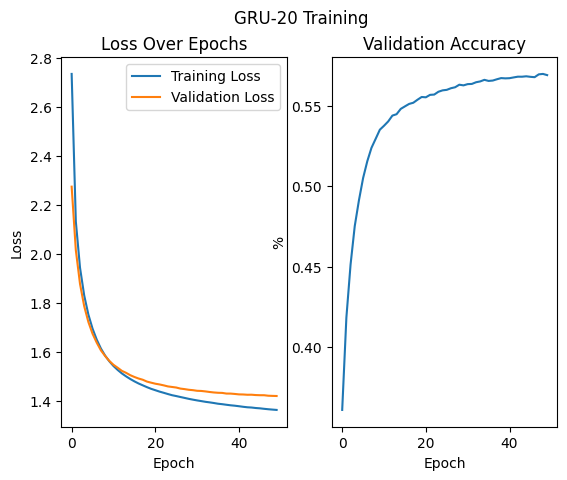

In [3]:
for model in models:
    del model

gru_20 = ShakespeareRNN(
    alphabet_size=len(data_20['chars']),
    hidden_size=128,
    rnn=nn.GRU,
).to('cuda')
models.append(gru_20)
train_and_plot(
    data_20['train_loader'],
    data_20['val_loader'],
    gru_20,
    "GRU-20",
    epochs=50,
    optimizer = torch.optim.Adam,
    optimizer_kwargs = {'lr': 0.001},
    min_accuracy = 0.99,
    max_negative_diff_count = 7   
)

# GRU-Adjusted-20

Training GRU-Adjusted-20
Model has 176477 parameters
Training ShakespeareRNN

----------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------


/home/jaskin/Intro_Deep_Learning/HM3/jlib/classifier.py:108: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  self.last_val = torch.tensor(val_loader.data_iterable.dataset.dataset.targets)


|       Epoch        |   Epoch Time (s)   |   Training Loss    |     Test Loss      |    Overfit (%)     |    Accuracy (%)    |   Δ Accuracy (%)   | Avg Inference Time |  GPU Memory (GiB)  |
----------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
|         0          |      8.834196      |      2.052997      |      1.694339      |     -17.469942     |     49.255632      |      0.000000      |    3.727848e-07    |      1.829890      |
----------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
|         1          |      6.296373      |      1.693039      |      1.581314      |     -6.599079      |     52.291382      |      6.163255      |    2.369741e-07    |      2.017390      |
---------------------------------------------

/home/jaskin/Intro_Deep_Learning/HM3/jlib/classifier.py:237: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  self.last_pred = torch.tensor(Y_pred_eval)


Model has 176477 parameters


TypeError: Classifier.train_model() missing 2 required positional arguments: 'train_loader' and 'val_loader'

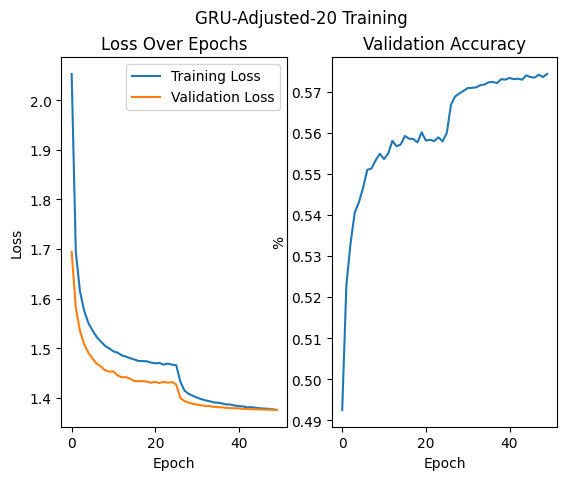

In [3]:
for model in models:
    del model

gru_adj_20 = ShakespeareRNN(
    alphabet_size=len(data_20['chars']),
    hidden_size=100,
    rnn=nn.GRU,
    linear_network=[256,256],
    dropout=0.3
).to('cuda')
models.append(gru_adj_20)
train_and_plot(
    data_20['train_loader'],
    data_20['val_loader'],
    gru_adj_20,
    "GRU-Adjusted-20",
    epochs=50,
    optimizer = torch.optim.Adam,
    optimizer_kwargs = {'lr': 0.01},
    min_accuracy = 0.99,
    max_negative_diff_count = 7   
)

# Data-30

In [2]:
for data in datas:
    del data

data_30 = get_shakespeare_loaders(
    train_batch_size=2**13,
    val_batch_size=2**15,
    sequence_length=20,
)
datas.append(data_30)

Train GPU Prefetch: 3200.0
Train CPU Prefetch: 320.0
Val GPU Prefetch: 400.0
Val CPU Prefetch: 80.0
Train Loader
Begin init data loader
Batch Size: 1.25 MiB
Data Loader init time: 3.247957 s
Begin init fetcher
Fetcher init time: 3.682173 s
Val Loader
Begin init data loader
Batch Size: 5.0 MiB
Data Loader init time: 2.662572 s
Begin init fetcher
Fetcher init time: 2.858340 s


# LSTM-30

Training LSTM-30
Model has 148801 parameters
Training ShakespeareRNN

----------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------


/home/jaskin/Intro_Deep_Learning/HM3/jlib/classifier.py:108: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  self.last_val = torch.tensor(val_loader.data_iterable.dataset.dataset.targets)


|       Epoch        |   Epoch Time (s)   |   Training Loss    |     Test Loss      |    Overfit (%)     |    Accuracy (%)    |   Δ Accuracy (%)   | Avg Inference Time |  GPU Memory (GiB)  |
----------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
|         0          |     11.191236      |      2.825303      |      2.344658      |     -17.012153     |     33.736636      |      0.000000      |    3.981310e-07    |      5.903687      |
----------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
|         1          |      5.676796      |      2.198852      |      2.085727      |     -5.144760      |     40.033621      |     18.665125      |    5.603821e-08    |      6.089234      |
---------------------------------------------

/home/jaskin/Intro_Deep_Learning/HM3/jlib/classifier.py:237: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  self.last_pred = torch.tensor(Y_pred_eval)


Model has 148801 parameters


TypeError: Classifier.train_model() missing 2 required positional arguments: 'train_loader' and 'val_loader'

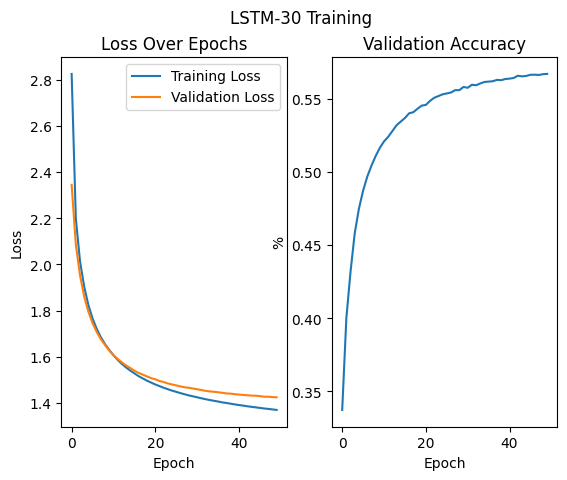

In [3]:
for model in models:
    del model


lstm30 = ShakespeareRNN(
    alphabet_size=len(data_30['chars']),
    hidden_size=128,
    rnn=nn.LSTM,
).to('cuda')
models.append(lstm30)
train_and_plot(
    data_30['train_loader'],
    data_30['val_loader'],
    lstm30,
    "LSTM-30",
    epochs=50,
    optimizer = torch.optim.Adam,
    optimizer_kwargs = {'lr': 0.001},
    min_accuracy = 0.99,
    max_negative_diff_count = 7   
)

# LSTM-Adjusted-30

In [ ]:
for model in models:
    del model
lstmadj_30 = ShakespeareRNN(
    alphabet_size=len(data_30['chars']),
    hidden_size=100,
    rnn=nn.LSTM,
    linear_network=[128,64],
    dropout=0.3
).to('cuda')
models.append(lstmadj_30)
train_and_plot(
    data_30['train_loader'],
    data_30['val_loader'],
    lstmadj_30,
    "LSTM-Adjusted-30",
    epochs=50,
    optimizer = torch.optim.Adam,
    optimizer_kwargs = {'lr': 0.001},
    min_accuracy = 0.99,
    max_negative_diff_count = 7   
)

# GRU-30

Training GRU-30
Model has 115777 parameters
Training ShakespeareRNN

----------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------


/home/jaskin/Intro_Deep_Learning/HM3/jlib/classifier.py:108: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  self.last_val = torch.tensor(val_loader.data_iterable.dataset.dataset.targets)


|       Epoch        |   Epoch Time (s)   |   Training Loss    |     Test Loss      |    Overfit (%)     |    Accuracy (%)    |   Δ Accuracy (%)   | Avg Inference Time |  GPU Memory (GiB)  |
----------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
|         0          |      8.650820      |      2.727378      |      2.272147      |     -16.691181     |     36.085173      |      0.000000      |    1.435001e-07    |      4.963742      |
----------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
|         1          |      5.455945      |      2.128140      |      2.015325      |     -5.301138      |     41.681049      |     15.507410      |    5.557695e-08    |      5.151242      |
---------------------------------------------

/home/jaskin/Intro_Deep_Learning/HM3/jlib/classifier.py:237: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  self.last_pred = torch.tensor(Y_pred_eval)


Model has 115777 parameters


TypeError: Classifier.train_model() missing 2 required positional arguments: 'train_loader' and 'val_loader'

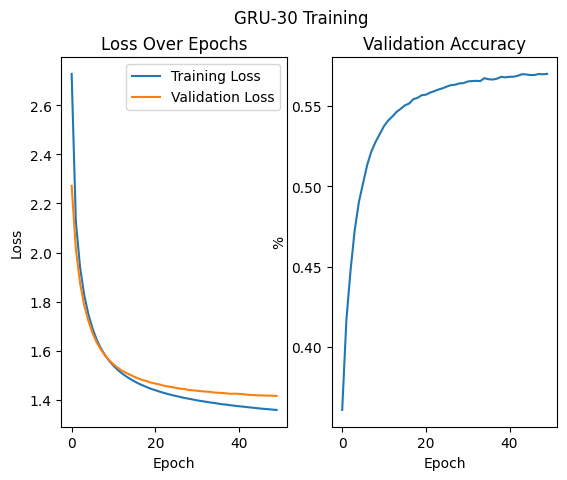

In [3]:
gru_30 = ShakespeareRNN(
    alphabet_size=len(data_30['chars']),
    hidden_size=128,
    rnn=nn.GRU,
).to('cuda')
models.append(gru_30)
train_and_plot(
    data_30['train_loader'],
    data_30['val_loader'],
    gru_30,
    "GRU-30",
    epochs=50,
    optimizer = torch.optim.Adam,
    optimizer_kwargs = {'lr': 0.001},
    min_accuracy = 0.99,
    max_negative_diff_count = 7   
)

# GRU-Adjusted-30

In [ ]:
for model in models:
    del model
gru_adj_30 = ShakespeareRNN(
    alphabet_size=len(data_30['chars']),
    hidden_size=100,
    rnn=nn.GRU,
    linear_network=[128,64],
    dropout=0.3
)
models.append(gru_adj_30)
train_and_plot(
    data_30['train_loader'],
    data_30['val_loader'],
    gru_adj_30,
    "GRU-Adjusted-30",
    epochs=50,
    optimizer = torch.optim.Adam,
    optimizer_kwargs = {'lr': 0.001},
    min_accuracy = 0.99,
    max_negative_diff_count = 7   
)

# Data-50

In [ ]:
for data in datas:
    del data

data_50 = get_shakespeare_loaders(
    train_batch_size=2**13,
    val_batch_size=2**15,
    sequence_length=20,
)
datas.append(data_50)

# LSTM-50

In [ ]:
for model in models:
    del model
    
lstm50 = ShakespeareRNN(
    alphabet_size=len(data_50['chars']),
    hidden_size=128,
    rnn=nn.LSTM,
).to('cuda')
models.append(lstm50)
train_and_plot(
    data_50['train_loader'],
    data_50['val_loader'],
    lstm50,
    "LSTM-50",
    epochs=50,
    optimizer = torch.optim.Adam,
    optimizer_kwargs = {'lr': 0.001},
    min_accuracy = 0.99,
    max_negative_diff_count = 7   
)

# LSTM-Adjusted-50

In [ ]:
lstmadj_50 = ShakespeareRNN(
    alphabet_size=len(data_50['chars']),
    hidden_size=100,
    rnn=nn.LSTM,
    linear_network=[128,64],
    dropout=0.3
).to('cuda')
models.append(lstmadj_50)

train_and_plot(
    data_50['train_loader'],
    data_50['val_loader'],
    lstmadj_50,
    "LSTM-Adjusted-50",
    epochs=50,
    optimizer = torch.optim.Adam,
    optimizer_kwargs = {'lr': 0.001},
    min_accuracy = 0.99,
    max_negative_diff_count = 7   
)


# GRU-50

In [ ]:
for model in models:
    del model
gru_50 = ShakespeareRNN(
    alphabet_size=len(data_50['chars']),
    hidden_size=128,
    rnn=nn.GRU,
).to('cuda')

models.append(gru_50)

train_and_plot(
    data_50['train_loader'],
    data_50['val_loader'],
    gru_50,
    "GRU-50",
    epochs=50,
    optimizer = torch.optim.Adam,
    optimizer_kwargs = {'lr': 0.001},
    min_accuracy = 0.99,
    max_negative_diff_count = 7   
)

# GRU-Adjusted-50

In [ ]:
gru_adj_50 = ShakespeareRNN(
    alphabet_size=len(data_50['chars']),
    hidden_size=100,
    rnn=nn.GRU,
    linear_network=[128,64],
    dropout=0.3
).to('cuda')
models.append(gru_adj_50)
train_and_plot(
    data_50['train_loader'],
    data_50['val_loader'],
    gru_adj_50,
    "GRU-Adjusted-50",
    epochs=50,
    optimizer = torch.optim.Adam,
    optimizer_kwargs = {'lr': 0.001},
    min_accuracy = 0.99,
    max_negative_diff_count = 7   
)